In [112]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import folium
from folium.element import IFrame
from folium.plugins import MarkerCluster

ModuleNotFoundError: No module named 'folium.element'

## Read data

### frequency for each routes

In [41]:
freq_data=pd.read_csv('output/freq_at_stops_by_routes_data_only_freq.csv')
freq_data.drop(columns=['Unnamed: 0'], inplace=True)
#stops_data.set_index('stop_id',inplace=True)
print(freq_data.shape)
freq_data.head()

(358620, 7)


agency  route_id  service_id  shape_id                   interval  \
0   DDOT      6996           1     53928  Late Night (11 pm - 4 am)   
1   DDOT      6996           1     53928        Early (4 am - 6 am)   
2   DDOT      6996           1     53928      AM Peak (6 am - 9 am)   
3   DDOT      6996           1     53928       Midday (9 am - 3 pm)   
4   DDOT      6996           1     53928      PM Peak (3 pm - 7 pm)   

       count   avg_freq  
0   1.522727  40.000000  
1   3.863636  31.564394  
2   8.840909  20.118561  
3  15.431818  23.446591  
4   9.318182  25.529924

In [42]:
freq_data.describe(include='all')

agency       route_id     service_id       shape_id  \
count   358620  358620.000000  358620.000000  358620.000000   
unique       2            NaN            NaN            NaN   
top       DDOT            NaN            NaN            NaN   
freq    179310            NaN            NaN            NaN   
mean       NaN    7369.883721   13312.200000   54124.784173   
std        NaN    2289.914598   16301.621955    1325.310341   
min        NaN    6996.000000       1.000000   53928.000000   
25%        NaN    7006.000000       2.000000   53971.000000   
50%        NaN    7017.000000       3.000000   54016.000000   
75%        NaN    7028.000000   33276.000000   54052.000000   
max        NaN   22210.000000   33279.000000   69683.000000   

                         interval        count     avg_freq  
count                      358620  1167.000000  1001.000000  
unique                          6          NaN          NaN  
top     Late Night (11 pm - 4 am)          NaN          NaN  
freq                        59770          NaN          NaN  
mean                          NaN     4.954349    43.645106  
std                           NaN     4.250190    15.454107  
min                           NaN     1.000000    11.355185  
25%                           NaN     2.000000    30.000000  
50%                           NaN     4.000000    45.000000  
75%                           NaN     6.179971    59.564925  
max                           NaN    31.081967   120.072464

### route shapes

In [50]:
gtfs_path=[r'data/DDOT/',r'data/DPM/']

route_points_df=pd.DataFrame()
for agencies in gtfs_path:
    shapes_df=pd.read_csv(agencies+'shapes.txt')
    
    route_data=pd.DataFrame(shapes_df['shape_id'].unique(), columns=['shape_id'])
    route_data['points_list']=route_data.apply(lambda x: 
                                               shapes_df[shapes_df['shape_id']==x['shape_id']][['shape_pt_lat','shape_pt_lon']]
                                               .values.tolist(),axis=1)
    route_data['agency']=agencies[5:-1]
    route_points_df=route_points_df.append(route_data)

print(route_points_df.shape)
route_points_df.head()

(141, 3)


shape_id                                        points_list agency
0     53928  [[42.3215, -83.177301], [42.3219, -83.176001],...   DDOT
1     53929  [[42.332699, -83.05319899999999], [42.333899, ...   DDOT
2     53930  [[42.319231, -83.217762], [42.318703, -83.2174...   DDOT
3     53931  [[42.3164, -83.195101], [42.3169, -83.1933], [...   DDOT
4     53932  [[42.332699, -83.0522], [42.333899, -83.0522],...   DDOT

### merge two data sets

In [69]:
#create average frequency of each interval in new column
freq_data1=pd.pivot_table(freq_data,
               values=['avg_freq'],
               columns='interval',
               index=['agency','route_id','service_id','shape_id']).reset_index()

map_data=pd.merge(freq_data1,route_points_df,on=['agency','shape_id'], how='left')#.describe(include='all')
map_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


agency  shape_id (agency, )  (route_id, )  (service_id, )  (shape_id, )  \
0   DDOT     53928       DDOT          6996               1         53928   
1   DDOT     53929       DDOT          6996               1         53929   
2   DDOT     53928       DDOT          6996               2         53928   
3   DDOT     53929       DDOT          6996               2         53929   
4   DDOT     53928       DDOT          6996               3         53928   

   (avg_freq, AM Peak (6 am - 9 am))  (avg_freq, Early (4 am - 6 am))  \
0                          20.118561                        31.564394   
1                          19.954965                        37.086170   
2                          33.624242                        46.863636   
3                          38.401773                        50.000000   
4                          55.821970                        55.000000   

   (avg_freq, Evening (7 pm - 11 pm))  (avg_freq, Late Night (11 pm - 4 am))  \
0                           48.000758                                   40.0   
1                           46.317730                                   40.0   
2                           44.070833                                   50.0   
3                           41.327305                                   50.0   
4                           55.000000                                    NaN   

   (avg_freq, Midday (9 am - 3 pm))  (avg_freq, PM Peak (3 pm - 7 pm))  \
0                         23.446591                          25.529924   
1                         23.734752                          22.788652   
2                         25.093182                          30.753030   
3                         25.221986                          27.858156   
4                         55.000000                          54.199242   

                                         points_list  
0  [[42.3215, -83.177301], [42.3219, -83.176001],...  
1  [[42.332699, -83.05319899999999], [42.333899, ...  
2  [[42.3215, -83.177301], [42.3219, -83.176001],...  
3  [[42.332699, -83.05319899999999], [42.333899, ...  
4  [[42.3215, -83.177301], [42.3219, -83.176001],...

In [70]:
map_data.describe(include='all')

agency      shape_id (agency, )  (route_id, )  (service_id, )  \
count     266    266.000000        266    266.000000       266.00000   
unique      2           NaN          2           NaN             NaN   
top      DDOT           NaN       DDOT           NaN             NaN   
freq      264           NaN        264           NaN             NaN   
mean      NaN  54120.710526        NaN   7129.214286       252.06015   
std       NaN   1357.978260        NaN   1315.134338      2879.91417   
min       NaN  53928.000000        NaN   6996.000000         1.00000   
25%       NaN  53959.000000        NaN   7007.000000         1.00000   
50%       NaN  53996.000000        NaN   7015.000000         2.00000   
75%       NaN  54046.500000        NaN   7023.750000         3.00000   
max       NaN  69683.000000        NaN  22210.000000     33279.00000   

        (shape_id, )  (avg_freq, AM Peak (6 am - 9 am))  \
count     266.000000                         215.000000   
unique           NaN                                NaN   
top              NaN                                NaN   
freq             NaN                                NaN   
mean    54120.710526                          42.922094   
std      1357.978260                          15.656008   
min     53928.000000                          11.355185   
25%     53959.000000                          30.000000   
50%     53996.000000                          45.054348   
75%     54046.500000                          60.000000   
max     69683.000000                          65.000000   

        (avg_freq, Early (4 am - 6 am))  (avg_freq, Evening (7 pm - 11 pm))  \
count                        147.000000                          146.000000   
unique                              NaN                                 NaN   
top                                 NaN                                 NaN   
freq                                NaN                                 NaN   
mean                          40.460329                           49.649031   
std                           15.692452                           11.287785   
min                           15.329815                           21.365301   
25%                           29.898234                           41.749645   
50%                           39.191489                           52.371974   
75%                           50.000000                           60.000000   
max                          116.000000                           65.000000   

        (avg_freq, Late Night (11 pm - 4 am))  \
count                               47.000000   
unique                                    NaN   
top                                       NaN   
freq                                      NaN   
mean                                37.829687   
std                                  9.857284   
min                                 24.245283   
25%                                 30.000000   
50%                                 35.000000   
75%                                 45.000000   
max                                 60.000000   

        (avg_freq, Midday (9 am - 3 pm))  (avg_freq, PM Peak (3 pm - 7 pm))  \
count                         220.000000                         226.000000   
unique                               NaN                                NaN   
top                                  NaN                                NaN   
freq                                 NaN                                NaN   
mean                           44.287384                          43.109976   
std                            17.111363                          15.598288   
min                            11.635246                          11.423563   
25%                            30.000000                          29.911644   
50%                            50.000000                          44.451626   
75%                            60.000000                          59.175028   
max                       

## Basic data exploration

In [21]:
freq_data.describe(include='all')

agency      route_id   service_id                   interval  \
count    2580   2580.000000   2580.00000                       2580   
unique      2           NaN          NaN                          6   
top       DPM           NaN          NaN  Late Night (11 pm - 4 am)   
freq     1290           NaN          NaN                        430   
mean      NaN   7369.883721  13312.20000                        NaN   
std       NaN   2290.355315  16304.75937                        NaN   
min       NaN   6996.000000      1.00000                        NaN   
25%       NaN   7006.000000      2.00000                        NaN   
50%       NaN   7017.000000      3.00000                        NaN   
75%       NaN   7028.000000  33276.00000                        NaN   
max       NaN  22210.000000  33279.00000                        NaN   

             count    avg_freq  
count   548.000000  516.000000  
unique         NaN         NaN  
top            NaN         NaN  
freq           NaN         NaN  
mean      5.383581   42.730428  
std       4.363013   14.552522  
min       1.000000   11.591026  
25%       2.333948   29.995346  
50%       4.144414   44.580035  
75%       6.561106   58.761146  
max      31.427350   71.475944

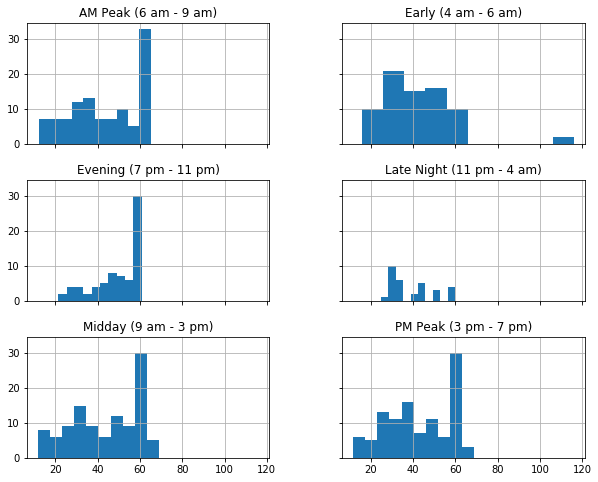

In [57]:
freq_timeofday=pd.pivot_table(freq_data,
                                   values=['avg_freq'],
                                   columns='interval',
                                   index=['route_id','service_id'])
_=freq_timeofday['avg_freq'].hist(figsize=(10,8),sharey=True, sharex=True)

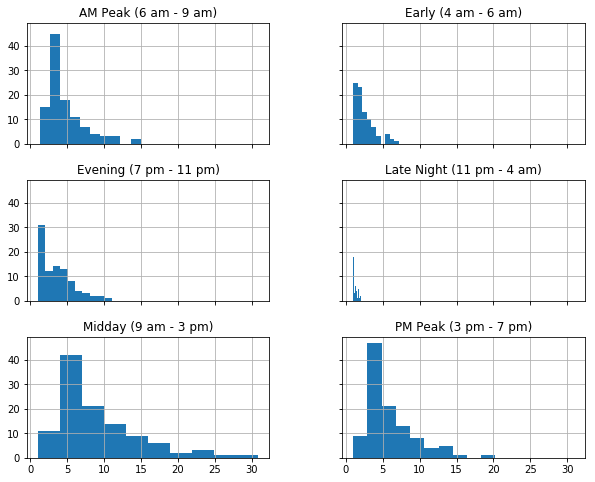

In [58]:
stop_count_timeofday=pd.pivot_table(freq_data,
                                   values=['count'],
                                   columns='interval',
                                   index=['route_id','service_id'])
_=stop_count_timeofday['count'].hist(figsize=(10,8),sharey=True, sharex=True)

## Map

#### Test folium

In [98]:
folium_map = folium.Map(location=[42.347, -83.056],
                        zoom_start=11,
                        tiles="CartoDB dark_matter")

folium.CircleMarker(location=[42.347, -83.056],fill=True).add_to(folium_map)

#add lines
for routes in route_data['route_id']:
    #folium.PolyLine(route_data.iloc[0,1], color="red", weight=2.5, opacity=1).add_to(folium_map)
    route_data.apply(lambda x: folium.PolyLine(x['points_list'], 
                                               color="red", 
                                               weight=2, 
                                               opacity=1).add_to(folium_map), axis=1)
folium_map


KeyError: 'route_id'

In [114]:
def plot_station_counts(map_data):
    # generate a new map
    folium_map = folium.Map(location=[42.347, -83.056],
                            zoom_start=12,
                            tiles='cartodbpositron') #"CartoDB dark_matter"

    # for each row in the data, add a cicle marker
    for index, row in map_data.iterrows():
                
#         # generate the popup message that is shown on click.
#         popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
#         popup_text = popup_text.format(row["Start Station Name"],
#                           row["Arrival Count"],
#                           row["Departure Count"],
#                           net_departures)
        
#         # radius of circles
#         radius = net_departures/20
        #         # choose the color of the marker
#         if net_departures>0:
#             # color="#FFCE00" # orange
#             # color="#007849" # green
#             color="#E37222" # tangerine
#         else:
#             # color="#0375B4" # blue
#             # color="#FFCE00" # yellow            
#             color="#0A8A9F" # teal
        
#         # add marker to the map
#         folium.CircleMarker(location=(row["stop_lat"],
#                                       row["stop_lon"]),
#                             radius=row['count']/50,
#                             color="#0A8A9F",
#                             #popup=popup_text,
#                             fill=True).add_to(folium_map)

        
        if (row['freq']<=10):
            color="#007849" # green
        elif (row['freq']>10) & (row['freq']<=20):
            color="#FFCE00" # yellow 
        elif (row['freq']>20) & (row['freq']<=60):
            color="#E37222" # tangerine
        else:
            color="#0A8A9F" # teal
        
        
        folium.vector_layers.PolyLine(row['points_list'],
                        color=color,
                        weight=2, 
                        opacity=1).add_to(folium_map)
    
    pt_lyr = folium.FeatureGroup(name = 'AM peak')
    
    folium.LayerControl().add_to(folium_map)
    return folium_map

plot_data=map_data[['shape_id',('avg_freq','AM Peak (6 am - 9 am)'),'points_list']].rename(columns={'shape_id':'shape_id',
                                                                                         ('avg_freq','AM Peak (6 am - 9 am)'):'freq',
                                                                                         'points_list':'points_list'})
plot_station_counts(plot_data).save("visualization_test1.html")


In [102]:
plot_data=map_data[['shape_id',('avg_freq','AM Peak (6 am - 9 am)'),'points_list']].rename(columns={'shape_id':'shape_id',
                                                                                         ('avg_freq','AM Peak (6 am - 9 am)'):'freq',
                                                                                         'points_list':'points_list'})
coords, popups = [], [] 

for index, row in plot_data.iterrows():
    
    #Append lat and long coordinates to "coords" list
    coords.append(row['points_list'])
    #Create a string of HTML code used in the IFrame popup
    #Join together the fields in "popup_field_list" with a linebreak between them
    label = append(row['avg_freq']
    #Append an IFrame that uses the HTML string to the "popups" list 
    popups.append(IFrame(label, width = 300, height = 100))
    
    if (row['freq']<=10):
        color="#007849" # green
    elif (row['freq']>10) & (row['freq']<=20):
        color="#FFCE00" # yellow 
    elif (row['freq']>20) & (row['freq']<=60):
        color="#FFCE00" # orange
    else:
        color="#E37222" # tangerine
    

SyntaxError: invalid syntax (<ipython-input-102-955fd96c0123>, line 14)

In [86]:
map_data[['shape_id',('avg_freq','AM Peak (6 am - 9 am)'),'points_list']].rename(columns={'shape_id':'shape_id',
                                                                                         ('avg_freq','AM Peak (6 am - 9 am)'):'freq',
                                                                                         'points_list':'points_list'})

shape_id       freq                                        points_list
0       53928  20.118561  [[42.3215, -83.177301], [42.3219, -83.176001],...
1       53929  19.954965  [[42.332699, -83.05319899999999], [42.333899, ...
2       53928  33.624242  [[42.3215, -83.177301], [42.3219, -83.176001],...
3       53929  38.401773  [[42.332699, -83.05319899999999], [42.333899, ...
4       53928  55.821970  [[42.3215, -83.177301], [42.3219, -83.176001],...
5       53929  56.217376  [[42.332699, -83.05319899999999], [42.333899, ...
6       53930  20.071277  [[42.319231, -83.217762], [42.318703, -83.2174...
7       53931        NaN  [[42.3164, -83.195101], [42.3169, -83.1933], [...
8       53932  20.146541  [[42.332699, -83.0522], [42.333899, -83.0522],...
9       53930  29.997872  [[42.319231, -83.217762], [42.318703, -83.2174...
10      53931        NaN  [[42.3164, -83.195101], [42.3169, -83.1933], [...
11      53932  30.011321  [[42.332699, -83.0522], [42.333899, -83.0522],...
12      53930  39.542908  [[42.319231, -83.217762], [42.318703, -83.2174...
13      53931        NaN  [[42.3164, -83.195101], [42.3169, -83.1933], [...
14      53932  45.454088  [[42.332699, -83.0522], [42.333899, -83.0522],...
15      53933        NaN  [[42.332699, -83.0522], [42.333899, -83.0522],...
16      53934  11.355185  [[42.428399, -83.2877], [42.428090000000005, -...
17      53936  15.207341  [[42.331342, -83.04016700000001], [42.330899, ...
18      53934  22.687963  [[42.428399, -83.2877], [42.428090000000005, -...
19      53936  26.365675  [[42.331342, -83.04016700000001], [42.330899, ...
20      53934  29.181111  [[42.428399, -83.2877], [42.428090000000005, -...
21      53936  30.838690  [[42.331342, -83.04016700000001], [42.330899, ...
22      53937  12.062022  [[42.442122999999995, -83.119784], [42.4419900...
23      53938  12.046264  [[42.329699, -83.045099], [42.330399, -83.0455...
24      53937  17.264208  [[42.442122999999995, -83.119784], [42.4419900...
25      53938  17.805460  [[42.329699, -83.045099], [42.330399, -83.0455...
26      53937  24.059836  [[42.442122999999995, -83.119784], [42.4419900...
27      53938  23.873851  [[42.329699, -83.045099], [42.330399, -83.0455...
28      53939  20.691447  [[42.332699, -83.0522], [42.333899, -83.0522],...
29      53940  20.940222  [[42.448199, -83.021499], [42.448299, -83.0223...
..        ...        ...                                                ...
236     54071  36.041667  [[42.473898999999996, -83.2408], [42.472799, -...
237     54072  35.504472  [[42.318253000000006, -83.217253], [42.318703,...
238     54071  60.000000  [[42.473898999999996, -83.2408], [42.472799, -...
239     54072  60.000000  [[42.318253000000006, -83.217253], [42.318703,...
240     54073  34.743333  [[42.332699, -83.0522], [42.333899, -83.0522],...
241     54074  34.405039  [[42.417099, -82.9109], [42.417899, -82.9129],...
242     54073  61.616296  [[42.332699, -83.0522], [42.333899, -83.0522],...
243     54074  61.494186  [[42.417099, -82.9109], [42.417899, -82.9129],...
244     54073  61.691296  [[42.332699, -83.0522], [42.333899, -83.0522],...
245     54074  61.904264  [[42.417099, -82.9109], [42.417899, -82.9129],...
246     54082  37.207602  [[42.367098999999996, -82.97059899999999], [42...
247     54085  35.000000  [[42.4491, -82.985601], [42.448399, -82.9857],...
248     54082  60.923099  [[42.367098999999996, -82.97059899999999], [42...
249     54085  60.809420  [[42.4491, -82.985601], [42.448399, -82.9857],...
250     54082  60.000000  [[42.367098999999996, -82.97059899999999], [42...
251     54085  60.000000  [[42.4491, -82.985601], [42.448399, -82.9857],...
252     54090  29.701754  [[42.375799, -82.9379], [42.375499, -82.9386],...
253     54091        NaN  [[42.366099, -83.0848], [42.366799, -83.082599...
254     54092        NaN  [[42.366099, -83.0848], [42.366799, -83.082599...
255     54093  39.756989  [[42.261998999999996, -83.166899], [42.260899,...
256     54094  35.300333  [[42.436499, -83.2404], [42